# Final Project: Census Data

2) Compare income levels for a variety of levels of education for whites and non-whites. You can do this in several states, optionally but you must do at least one. You will need to turn in the Python notebook, some prose and explaining and justifying what you did (2 pages), and you need to produce some graphs plotting education level (x axis) and income levels (y axis). Make sure you can get the data for whites and non-whites on one plot. Use different colored lines. Your intellectual goal is to decide if differences in education level explain the differences in income for whites and non whites, or whether there are other major factors.

###### Code Below Assumes jupyter notebook with following files downloaded in same directory as this notebook:
https://gawron.sdsu.edu/python_for_ss/course_core/book_draft/_static/read_in_census_data.py

5%_PUMS_record_layout.xls

https://www2.census.gov/census_2000/datasets/PUMS/OnePercent/California/revisedpums1_06.txt 
https://www2.census.gov/census_2000/datasets/PUMS/OnePercent/New_York/revisedpums1_36.txt

In [1]:
import importlib.util
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'read_in_census_data.py'
spec = importlib.util.spec_from_file_location("census", filename)
# Name for imported module will be census
census = importlib.util.module_from_spec(spec)
spec.loader.exec_module(census)
one_percent_data_file_NY ='revisedpums1_NY.txt'   # renamed from revisedpums1_36.txt to revisedpums1_NY.txt
one_percent_data_file_CA = 'revisedpums1_CA.txt'  # renamed from revisedpums1_06.txt to revisedpums1_CA.txt
data_dictionary = '5%_PUMS_record_layout.xls'  
ci = census.CensusInfo (data_dictionary)
df = census.DataFrameWrapper(ci)
print(pd)

Processing 'Housing Unit Record' Sheet

Processing 'Person Record' Sheet

<module 'pandas' from '/Users/KelvinM/anaconda3/lib/python3.6/site-packages/pandas/__init__.py'>


In [2]:
ci.print_var_info ('education', ci.person_record)
ci.print_var_info ('race', ci.person_record)

Person Record education => EDUC 5% file {'RT': 'P', 'BEG': 53, 'LEN': 2, 'DESCRIPTION': 'Educational Attainment'}

     Educational Attainment
     00  Not in universe (Under 3 years)
     01  No schooling completed
     02  Nursery school to 4th grade
     03  5th grade or 6th grade
     04  7th grade or 8th grade
     05  9th grade
     06  10th grade
     07  11th grade
     08  12th grade, no diploma
     09  High school graduate
     10  Some college, but less than 1 year
     11  One or more years of college, no degree
     12  Associate degree
     13  Bachelor's degree
     14  Master's degree
     15  Professional degree
     16  Doctorate degree

Person Record race => RACE3 5% file {'RT': 'P', 'BEG': 41, 'LEN': 2, 'DESCRIPTION': 'Race Recode 3'}

     Race Recode 3
     01  Some other race alone
     02  Other Pacific Islander alone
     03  Other Pacific Islander; Some other race
     04  Samoan alone
     05  Guamanian or Chamorro alone
     06  Native Hawaiian alone
     0

In [3]:
df_NY = census.DataFrameWrapper(ci)
# we select a subset of the columns.
df_NY.fill_frame ([], ci.person_record, one_percent_data_file_NY, ci.one_percent_file, \
                'race','education','income','gender','age','relationship')
df_NY.rows[:5]

[['0000004', '47', '07', '000000', '1', '60', '01'],
 ['0000004', '47', '09', '015000', '2', '57', '02'],
 ['0000015', '47', '13', '050000', '1', '43', '01'],
 ['0000015', '47', '13', '030000', '2', '37', '02'],
 ['0000046', '47', '09', '000000', '1', '93', '01']]

In [4]:
df_CA = census.DataFrameWrapper(ci)
df_CA.fill_frame([],ci.person_record, one_percent_data_file_CA, ci.one_percent_file,\
                 'race','education','income','gender','age','relationship')
df_CA.rows[:5]


[['0000004', '47', '10', '090000', '1', '39', '01'],
 ['0000004', '47', '12', '040000', '2', '29', '02'],
 ['0000004', '47', '02', '      ', '2', '09', '03'],
 ['0000004', '47', '02', '      ', '2', '03', '03'],
 ['0000004', '47', '00', '      ', '1', '01', '03']]

### Convert dataframe wrappers to pandas dataframes

In [5]:
df_CA.save_frame('california_pums_extract.csv',header=True)
dt_dict ={'serial_no':object,'race':object,'gender':object,'relationship':object}
CA_df = pd.read_csv('california_pums_extract.csv',dtype=dt_dict)

df_NY.save_frame("newyork_pums_extract.csv",header=True)
NY_df = pd.read_csv("newyork_pums_extract.csv",dtype=dt_dict)



### Create a new Column determining if person is white or not

In [6]:
NY_df['white?'] = NY_df['race'].map(lambda x: x == '47')
CA_df["white?"] = CA_df["race"].map(lambda x: x == '47')

NY_df

,serial_no,race,education,income,gender,age,relationship,white?
0,0000004,47,7,0.0,1,60,01,True
1,0000004,47,9,15000.0,2,57,02,True
2,0000015,47,13,50000.0,1,43,01,True
3,0000015,47,13,30000.0,2,37,02,True
4,0000046,47,9,0.0,1,93,01,True
...,...,...,...,...,...,...,...,...
191428,0999965,47,9,22000.0,2,28,05,True
191429,0999979,47,11,0.0,1,75,01,True
191430,0999979,47,13,6000.0,2,58,02,True
191431,0999980,45,14,0.0,2,23,01,False


### Create bins for Education and create new column

In [7]:
def education (x):
    
    if 9 <= x <= 11:
        return 'HIGH SCHOOL'
    elif x == 12:
        return 'ASSOCIATE'
    elif x == 13:
        return "BACHELORS"
    elif x == 14:
        return "MASTERS"
    elif x > 14:
        return 'PROFESSIONAL/DOCTORATE'
    else:
        return 'NO DEGREE'
    
    
CA_df["Degrees"] = CA_df["education"].map(education)
NY_df["Degrees"] = NY_df["education"].map(education)

### Filter to those with income > 0 and group by white/non-white

In [8]:
CA_dfFixed = CA_df[CA_df["income"] > 0]
NY_dfFixed =    NY_df[NY_df["income"]>0]
aggregateWhiteCA = CA_dfFixed.groupby(["white?"]).mean().reset_index()
aggregateDegreeCA = CA_dfFixed.groupby(["Degrees"]).mean().reset_index()   
aggregateWhiteNY = NY_dfFixed.groupby(["white?"]).mean().reset_index()
aggregateDegreeNY = NY_dfFixed.groupby(["Degrees"]).mean().reset_index()

aggregateDegreeCA.sort_values("income",inplace=True)
aggregateDegreeCA.reset_index(inplace=True)

aggregateWhiteCA.sort_values("income",inplace=True)
aggregateWhiteCA.reset_index(inplace=True)

aggregateDegreeNY.sort_values("income",inplace=True)
aggregateDegreeNY.reset_index(inplace=True)

aggregateWhiteNY.sort_values("income",inplace=True)
aggregateWhiteNY.reset_index(inplace=True)

aggregateWhiteCA


,index,white?,education,income,age
0,0,False,9.251484,27585.034764,36.235332
1,1,True,10.594016,39530.994904,40.183901


### Graph general trends by race and degree

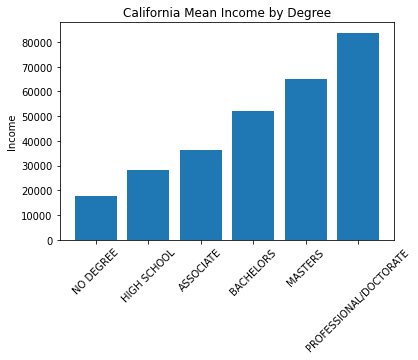

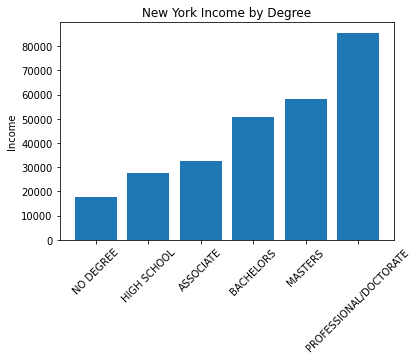

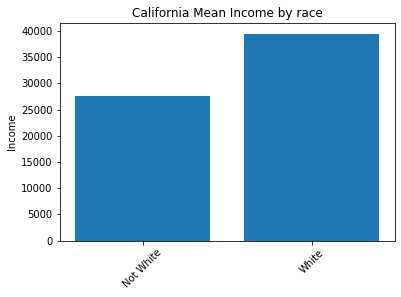

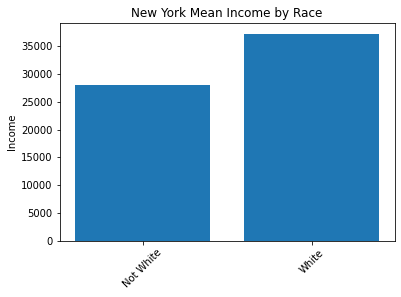

In [9]:
plt.bar(aggregateDegreeCA["Degrees"],aggregateDegreeCA["income"])
plt.xticks(rotation=45)
plt.ylabel("Income")
plt.title("California Mean Income by Degree")
plt.show()

plt.bar(aggregateDegreeNY["Degrees"],aggregateDegreeNY["income"])
plt.xticks(rotation=45)
plt.ylabel("Income")
plt.title("New York Income by Degree")
plt.show()

labels = ["Not White","White"]

plt.bar(labels,aggregateWhiteCA["income"])
plt.xticks(rotation=45)
plt.ylabel("Income")
plt.title("California Mean Income by race")
plt.show()

plt.bar(labels,aggregateWhiteNY["income"])
plt.xticks(rotation=45)
plt.ylabel("Income")
plt.title("New York Mean Income by Race")
plt.show()

### Create Graphs of each degree seperated by white (W) and non-white (NW) by mean income (California)

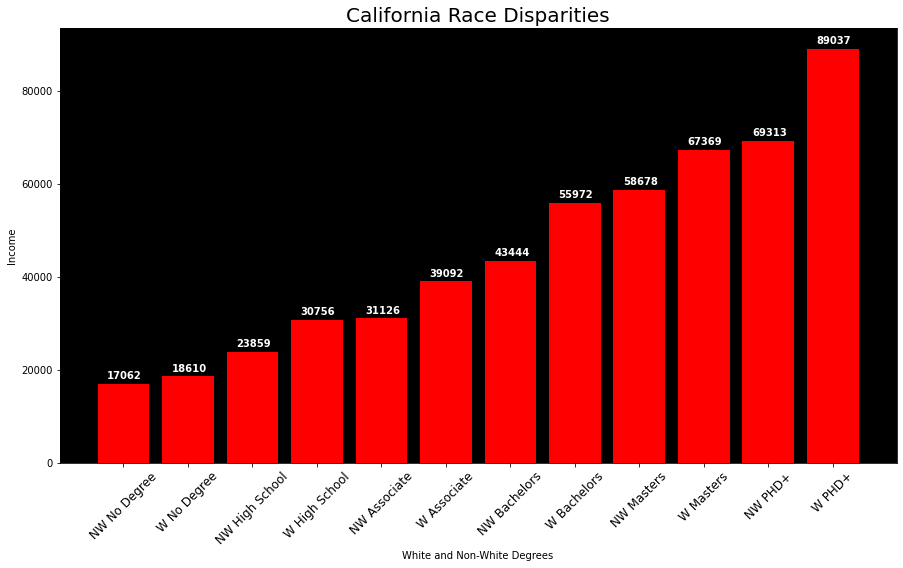

In [18]:

aggregateWhiteCA2 = CA_dfFixed.groupby(["white?","Degrees"]).mean().reset_index()
xlabels = ["NW No Degree","W No Degree","NW High School","W High School", \
           "NW Associate","W Associate","NW Bachelors","W Bachelors", \
           "NW Masters","W Masters","NW PHD+","W PHD+"]

aggregateWhiteCA2.sort_values("income",inplace=True)
plt.figure(figsize=(15,8))
plt.bar(xlabels,aggregateWhiteCA2["income"],color="red")
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='major', labelsize=12)
arrRound = [round(num)for num in aggregateWhiteCA2["income"]]
for i, v in enumerate(arrRound):
    plt.text(i - 0.25,v + 1000, str(v),color="white",fontweight="bold")
plt.ylabel("Income")
plt.xlabel("White and Non-White Degrees")
plt.title("California Race Disparities",fontsize = 20)
ax = plt.gca()
ax.set_facecolor('black')

### Create Graphs of each degree seperated by white (W) and non-white (NW) by mean income (New York)

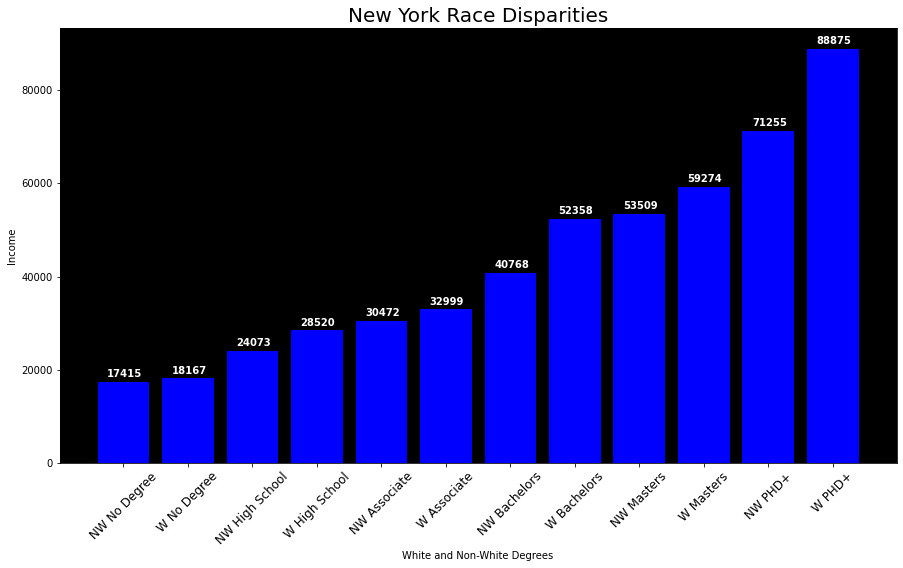

In [17]:
aggregateWhiteNY2 = NY_dfFixed.groupby(["white?","Degrees"]).mean().reset_index()
xlabels = ["NW No Degree","W No Degree","NW High School","W High School", \
           "NW Associate","W Associate","NW Bachelors","W Bachelors", \
           "NW Masters","W Masters","NW PHD+","W PHD+"]

aggregateWhiteNY2.sort_values("income",inplace=True)
plt.figure(figsize=(15,8))
plt.bar(xlabels,aggregateWhiteNY2["income"],color="blue")
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='major', labelsize=12)
arrRound = [round(num)for num in aggregateWhiteNY2["income"]]
for i, v in enumerate(arrRound):
    plt.text(i - 0.25,v + 1000, str(v),color="white",fontweight="bold")
plt.ylabel("Income")
plt.xlabel("White and Non-White Degrees")
plt.title("New York Race Disparities",fontsize = 20)
ax = plt.gca()
ax.set_facecolor('black')